## 1. Подготовка данных.

### Импортируем необходимые библиотеки.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import category_encoders as ce
from sklearn.feature_selection import f_classif

from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestRegressor  
from sklearn import metrics

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/country/country_code.csv
/kaggle/input/countries/countries.csv
/kaggle/input/sf-booking/hotels_test.csv
/kaggle/input/sf-booking/hotels_train.csv
/kaggle/input/sf-booking/submission.csv


In [2]:
# Путь к файлу.
INPUT_DIR = '../input/sf-booking/'

In [3]:
# Загружаем тренировочные данные.
hotels_train = pd.read_csv(INPUT_DIR + 'hotels_train.csv')
hotels_train.head(3)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,10/18/2016,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,7.5,"[' Leisure trip ', ' Solo traveler ', ' Modern...",289 day,48.845377,2.325643


In [4]:
# Загружаем тестовые данные.
hotels_test = pd.read_csv(INPUT_DIR + 'hotels_test.csv')
hotels_test.head(3)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,11/26/2015,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,5,15,"[' Business trip ', ' Solo traveler ', ' Twin ...",616 day,41.393192,2.161520


In [5]:
# Загружаем сабмишн файл.
submission = pd.read_csv(INPUT_DIR + 'submission.csv')
submission.head()

,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688
3,10,404352
4,9,451596


### Удаление дубликатов

In [6]:
# Находим дубликаты.
dupl_columns = list(hotels_train.columns)
data_duplicates = hotels_train[hotels_train.duplicated(subset=dupl_columns)]
print(f'Число найденных дубликатов: {data_duplicates.shape[0]}')

# Удаляем дубликаты.
hotels_train = hotels_train.drop_duplicates(subset=dupl_columns)
print(f'Результирующее число записей: {hotels_train.shape[0]}')

Число найденных дубликатов: 307
Результирующее число записей: 386496


## 2. Проектирование признаков.

In [7]:
# Объединяем тренировочный и тестовый датасет для дальней обработки и анализа.
hotels_train['sample'] = 1
hotels_test['sample'] = 0
hotels_test['reviewer_score'] = 0 
data = hotels_test.append(hotels_train, sort=False).reset_index(drop=True)
data.head(3)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng,sample,reviewer_score
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102,0,0.0
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443,0,0.0
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,11/26/2015,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,5,15,"[' Business trip ', ' Solo traveler ', ' Twin ...",616 day,41.393192,2.161520,0,0.0


In [8]:
# Выводим информацию о данных.
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515431 non-null  object 
 1   additional_number_of_scoring                515431 non-null  int64  
 2   review_date                                 515431 non-null  object 
 3   average_score                               515431 non-null  float64
 4   hotel_name                                  515431 non-null  object 
 5   reviewer_nationality                        515431 non-null  object 
 6   negative_review                             515431 non-null  object 
 7   review_total_negative_word_counts           515431 non-null  int64  
 8   total_number_of_reviews                     515431 non-null  int64  
 9   positive_review                             515431 non-null  object 
 

### Работа с пропусками.
#### Имеются пропуски в датасете в столбце lat и lng. Заполним их необходимыми данными.

In [9]:
# Выводим список адресов отелей с отсутствующими координатами.
data[data['lat'].isnull()].groupby(['hotel_address'])['hotel_address'].count().index.to_list()

['20 Rue De La Ga t 14th arr 75014 Paris France',
 '23 Rue Damr mont 18th arr 75018 Paris France',
 '4 rue de la P pini re 8th arr 75008 Paris France',
 'Bail n 4 6 Eixample 08010 Barcelona Spain',
 'Gr nentorgasse 30 09 Alsergrund 1090 Vienna Austria',
 'Hasenauerstra e 12 19 D bling 1190 Vienna Austria',
 'Josefst dter Stra e 10 12 08 Josefstadt 1080 Vienna Austria',
 'Josefst dter Stra e 22 08 Josefstadt 1080 Vienna Austria',
 'Landstra er G rtel 5 03 Landstra e 1030 Vienna Austria',
 'Paragonstra e 1 11 Simmering 1110 Vienna Austria',
 'Pau Clar s 122 Eixample 08009 Barcelona Spain',
 'Savoyenstra e 2 16 Ottakring 1160 Vienna Austria',
 'Sep lveda 180 Eixample 08011 Barcelona Spain',
 'Sieveringer Stra e 4 19 D bling 1190 Vienna Austria',
 'Taborstra e 8 A 02 Leopoldstadt 1020 Vienna Austria',
 'W hringer Stra e 12 09 Alsergrund 1090 Vienna Austria',
 'W hringer Stra e 33 35 09 Alsergrund 1090 Vienna Austria']

#### В списке всего 17 отелей. Поэтому создами словарь с координатами отелей.

In [10]:
# Словарь с шириной отелей.
lat_dict = {'Josefst dter Stra e 10 12 08 Josefstadt 1080 Vienna Austria': 48.209648,
 'Taborstra e 8 A 02 Leopoldstadt 1020 Vienna Austria': 48.213559,
 'W hringer Stra e 33 35 09 Alsergrund 1090 Vienna Austria': 48.220269,
 '4 rue de la P pini re 8th arr 75008 Paris France': 48.875140,
 'Landstra er G rtel 5 03 Landstra e 1030 Vienna Austria': 48.188888,
 'W hringer Stra e 12 09 Alsergrund 1090 Vienna Austria': 48.216778,
 'Savoyenstra e 2 16 Ottakring 1160 Vienna Austria': 48.215178,
 'Sieveringer Stra e 4 19 D bling 1190 Vienna Austria': 48.245887,
 'Bail n 4 6 Eixample 08010 Barcelona Spain': 41.391967,
 'Gr nentorgasse 30 09 Alsergrund 1090 Vienna Austria': 48.207910,
 'Hasenauerstra e 12 19 D bling 1190 Vienna Austria': 48.233562,
 'Josefst dter Stra e 22 08 Josefstadt 1080 Vienna Austria': 48.209580,
 '23 Rue Damr mont 18th arr 75018 Paris France': 48.884582,
 'Paragonstra e 1 11 Simmering 1110 Vienna Austria': 48.163757,
 '20 Rue De La Ga t 14th arr 75014 Paris France': 48.856818,
 'Pau Clar s 122 Eixample 08009 Barcelona Spain': 41.392789,
 'Sep lveda 180 Eixample 08011 Barcelona Spain': 41.384733}

# Словарь с долготой отелей.
lng_dict = {'Josefst dter Stra e 10 12 08 Josefstadt 1080 Vienna Austria': 16.353161,
 'Taborstra e 8 A 02 Leopoldstadt 1020 Vienna Austria': 16.380100,
 'W hringer Stra e 33 35 09 Alsergrund 1090 Vienna Austria': 16.355809,
 '4 rue de la P pini re 8th arr 75008 Paris France': 2.304705,
 'Landstra er G rtel 5 03 Landstra e 1030 Vienna Austria': 16.383891,
 'W hringer Stra e 12 09 Alsergrund 1090 Vienna Austria': 16.360074,
 'Savoyenstra e 2 16 Ottakring 1160 Vienna Austria': 16.303380,
 'Sieveringer Stra e 4 19 D bling 1190 Vienna Austria': 16.341940,
 'Bail n 4 6 Eixample 08010 Barcelona Spain': 2.175728,
 'Gr nentorgasse 30 09 Alsergrund 1090 Vienna Austria': 16.394933,
 'Hasenauerstra e 12 19 D bling 1190 Vienna Austria': 16.345668,
 'Josefst dter Stra e 22 08 Josefstadt 1080 Vienna Austria': 16.351433,
 '23 Rue Damr mont 18th arr 75018 Paris France': 2.324640,
 'Paragonstra e 1 11 Simmering 1110 Vienna Austria': 16.445799,
 '20 Rue De La Ga t 14th arr 75014 Paris France': 2.304722,
 'Pau Clar s 122 Eixample 08009 Barcelona Spain': 2.167397,
 'Sep lveda 180 Eixample 08011 Barcelona Spain': 2.160988}

In [11]:
def lat(arg):
    """Функция заполнения координаты ширины отеля"""
    if arg in lat_dict:
        return lat_dict[arg]
    
    
def lng(arg):
    """Функция заполнения координаты долготы отеля"""
    if arg in lng_dict:
        return lng_dict[arg]

# Заполняем пропуски с помощью функций. 
data['lat'] = data['lat'].fillna(data['hotel_address'].apply(lat))
data['lng'] = data['lng'].fillna(data['hotel_address'].apply(lng))

## Признак даты отзыва ['review_date'].
#### Переведем признак даты отзыва  в формат дыты и создадим новые признаки: месяц и день недели.

In [12]:
# Создаем признак месяца отзыва и дня недели. 
data['review_month'] = pd.to_datetime(data['review_date']).dt.month
data['review_week'] = pd.to_datetime(data['review_date']).dt.day_of_week

#### Посмотрим на среднюю оценку рецензента в зависимости от месяца и для недели отзыва.

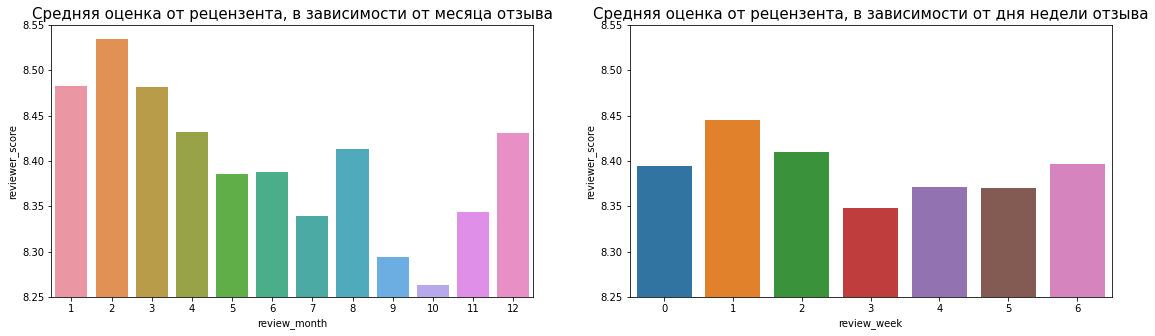

In [13]:
# Создадим таблицы с необходимыми данными для визуализации.
reviewer_score_month = data[data['sample']==1].pivot_table(
    values='reviewer_score', 
    index='review_month', 
    aggfunc='mean')
reviewer_score_week = data[data['sample']==1].pivot_table(
    values='reviewer_score', 
    index='review_week', 
    aggfunc='mean')

# Создаем фигуру для диаграмм.
fig, axs = plt.subplots(1, 2, figsize=(19, 5))

# Создаем стобчатую диаграмму зависимости оценки рецензента от месяца отзыва.
sns.barplot(
    data = reviewer_score_month,
    x = reviewer_score_month.index, 
    y = 'reviewer_score',
    ax = axs[0])

# Создаем стобчатую диаграмму зависимости оценки рецензента от для недели отзыва.
sns.barplot(
    data = reviewer_score_week,
    x = reviewer_score_week.index, 
    y = 'reviewer_score',
    ax = axs[1])

# Корректируем диаграмму для лучшей наглядности.
axs[0].set_title('Средняя оценка от рецензента, в зависимости от месяца отзыва',  
    fontsize=15)
axs[0].set_ylim(8.25, 8.55)
axs[1].set_title('Средняя оценка от рецензента, в зависимости от дня недели отзыва',  
    fontsize=15)
axs[1].set_ylim(8.25, 8.55);


##### Люди отправляющиеся на отдых в зимнее время ставят в среднем выше оценки.

## Признак адреса отеля ['hotel_address'].

In [14]:
def address(address):
    """Функция выведения города и страны нахождения отеля"""
    if 'Kingdom' in address:
        return address.split()[-5]+', United Kingdom'
    else:
        city = address.split()[-2::]
        return ', '.join(city)

# Создаем признак страны и города нахождения отеля.
data['country'] = data['hotel_address'].apply(address)

#### Посмотрим на среднюю оценку рецензента в зависимости от города отеля.

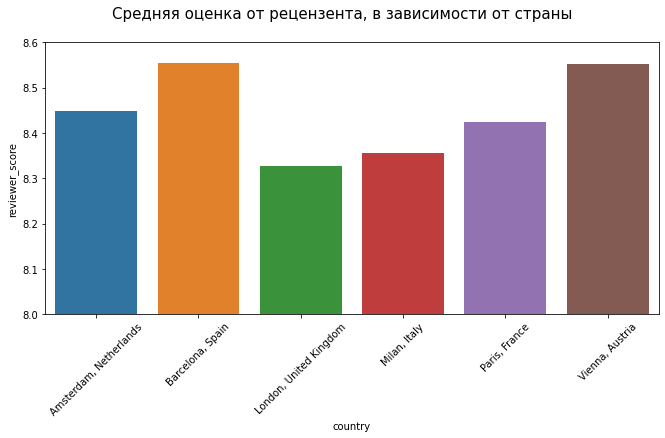

In [15]:
# Создадим таблицу с необходимыми данными для визуализации.
reviewer_score_country = data[data['sample']==1].pivot_table(
    values='reviewer_score', 
    index='country', 
    aggfunc='mean')

# Создаем столбчатую диаграмму.
plt.figure(figsize=(11, 5))
barplot_m = sns.barplot(
    data = reviewer_score_country,
    x = reviewer_score_country.index, 
    y = 'reviewer_score')

# Корректируем диаграмму для лучшей наглядности.
plt.suptitle('Средняя оценка от рецензента, в зависимости от страны',  
    fontsize=15)
plt.xticks(rotation= 45)
plt.ylim(8, 8.6);

##### Люди останавливающиеся с отелях Варселоны и Вены ставят немного выше оценки. 

### Признак национальности рецензента ['hotel_address'].

In [16]:
def nationality(arg):
    """Функция корректировки названий городов для дальнейшей обработки данных."""
    arg = arg[1:-1]
    if arg == 'United States of America':
        return arg.replace('United States of America', 'United States')
    elif arg == 'Bosnia and Herzegovina':
        return arg.replace('Bosnia and Herzegovina', 'Bosnia And Herzegovina')
    elif arg == 'Abkhazia Georgia':
        return arg.replace('Abkhazia Georgia', 'Georgia')
    elif arg == 'Brunei':
        return arg.replace('Brunei', 'Brunei Darussalam')
    return arg

# Запускаем функцию корректировки названий городов.
data['reviewer_nationality'] = data['reviewer_nationality'].apply(nationality)

#### Для дальнейшей обработки создадим новый признак с кодом страны рецензента.

In [17]:
# Загрузим датафрейм с кодами стран.
country = pd.read_csv('../input/country/' + 'country_code.csv')
country = country.rename(columns = {'name' : 'reviewer_nationality'})
country.head()

,reviewer_nationality,country-code
0,Afghanistan,4
1,Åland Islands,248
2,Albania,8
3,Algeria,12
4,American Samoa,16


In [18]:
# Подсоединяем к основному датафрейму коды стран.
data = pd.merge(data, country, how = 'left', on='reviewer_nationality')
data.head(3)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,...,tags,days_since_review,lat,lng,sample,reviewer_score,review_month,review_week,country,country-code
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,...,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102,0,0.0,7,4,"Milan, Italy",826.0
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,...,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443,0,0.0,12,0,"Amsterdam, Netherlands",56.0
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,11/26/2015,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,...,"[' Business trip ', ' Solo traveler ', ' Twin ...",616 day,41.393192,2.161520,0,0.0,11,3,"Barcelona, Spain",752.0


In [19]:
# Заполняем пропуски с неизвестными странами.
data['country-code'] = data['country-code'].fillna(1)

### Признак отрицательный отзыв ['negative_review'].

In [20]:
# Приведем отзывы к нижнему регистру и уберем пробелы в начале и конце.
data['negative_review'] = [x.lower().strip() for x in data['negative_review']]

In [21]:
# Создадим список ложно-отрицательных отзывов.
fake_neg_list1 = ['no negative', 'nothing', 'n a', 'none', '', 'nothing really', 'all good', 'no complaints', 'nothing at all', 'everything',
 'nothing to dislike', 'everything was perfect', 'nil',  'na', 'can t think of anything','leaving',  'absolutely nothing',
 'everything was great', 'nothing to complain about', 'no', 'nothing not to like',  'nothing all good','having to leave','not much',
 'i liked everything','everything was good', 'liked everything',  'nothing it was perfect','non','nothing everything was perfect',
 'nothing in particular', 'nothing everything was great','everything was fine', 'not applicable', 'all was good',               
 'nothing comes to mind', 'there was nothing i didn t like', 'not a thing', 'nothing i didn t like', 'no negatives','no complaints at all',
 'we liked everything', 'all ok', 'nothing to report', 'no thing', 'there was nothing to dislike', 'it was all good',
 'there was nothing we didn t like','loved everything', 'nothing i can think of', 'no dislikes', 'nothing to say',
 'nothing to mention', 'no bad experience', 'no issues', 'there was nothing not to like', 'nothing to complain', 'no comment', 
 'everything was ok', 'everything was excellent','no problems', 'nothing we didn t like', 'nada',
 'nothing special', 'nothing bad to say', 'nothing bad', 'all great', 'i loved everything', 'nothing could have been better',
 'liked it all', 'nothing to not like',              
 'couldn t fault it', 'no comments', 'going home', 'nothing it was all good', 'nothing much', 'that we had to leave',
 'it was perfect', 'nothing it was great', 'there wasn t anything we didn t like', 'nothing to fault',
 'what s not to like', 'loved it all', 'nothing all was good', 'nothing negative to say', 'cannot think of anything',
 'no bad experiences', 'i have no complaints', 'i liked it all', 'nothing all was great',
 'that we couldn t stay longer','all was great','nothing it was all great', 'that i couldn t stay longer',
 'nothing that i can think of', 'i can t think of anything', 'all was perfect', 'nothing of note',
 'it was all great', 'nothing springs to mind', 'nothing all great', 'couldn t fault anything',
 'no problems at all', 'nothing to add','that i had to leave', 'no faults', 'nope', 'all fine',
 'can t think of a thing', 'all perfect', 'there was nothing i did not like', 'everything perfect',
 'i had to leave', 'there wasn t anything i didn t like', 'all was fine', 'nothing everything was excellent',
 'no negative comments', 'nothing negative', 'all was ok', 'everything was very good', 'having to go home',
 'coming home', 'noting', 'we loved everything', 'nothing particular',
 'no complains', 'no complaints whatsoever', 'nithing', 'was all good',             
 'nothing specific', 'there was nothing we did not like', 'nothing all perfect', 'everything good',
 'nothing it was excellent', 'nothing i did not like', 'there was nothing that we didn t like',
 'can t think of any', 'zero', 'everything was fantastic', 'nothing worth mentioning',
 'could not fault anything', 'can t fault anything', 'nothing all was perfect', 'cant think of anything',
 'can t fault it', 'there was nothing that i didn t like', 'nothing perfect', 'happy with everything',
 'nothing loved it', 'nothings', 'nothin','really nothing', 'nothing everything was good', 'perfect',
 'nothing loved it all', 'we had to leave','nothing everything was fine', 'everything was wonderful',
 'nothing it was all perfect', 'nothing to note', 'nothing to complain about at all', 'not one thing',
 'all very good', 'good', 'there is nothing to dislike', 'nothing bad at all',
 'there wasn t anything not to like', 'all was excellent', 'we liked it all', 'anything',
 'nothing that i didn t like', 'no issues at all', 'nothing was bad', 'nothing bad to report',
 'having to come home', 'honestly nothing', 'everything ok',
 'wish i could have stayed longer', 'nothing all excellent',
 'nothing it was amazing', 'nothinh', 'can t think of anything we didn t like',
 'faultless', 'ok', 'no faults at all', 'everything was just perfect', 'everything is perfect',
 'couldn t fault the hotel', 'there was nothing to complain about', 'there was nothing',
 'i loved it all', 'nothing everything was fantastic', 'can t think of anything i didn t like',
 'not a single thing', 'nothing all was excellent', 'nothing to say here', 'nothing could be better',
 'nothing everything was brilliant', 'no negatives at all', 'nothing everything was just perfect',
 'i don t know', 'there is nothing not to like', 'everything was nice', 'couldn t stay longer',
 'all excellent', 'nothing to moan about', 'norhing', 'nothing so far', 'all is good',
 'nothing negative to report', 'nathing', 'nothing to improve', 'everything great',
 'i can t think of anything i didn t like', 'there wasn t anything',
 'there was nothing that i did not like', 'i cannot think of anything', 'nothing to comment',
 'no things',            
 'notting', 'no bad points', 'there was nothing that we did not like', 'nothing that we didn t like',
 'wish we could have stayed longer', 'everything was spot on','nothing actually',
 'a longer stay', 'nothing whatsoever', 'i like everything', 'nothink', 'everything was amazing',
 'nothing it was fantastic', 'nothing was perfect', 'can not think of anything',
 'nothing we loved everything', 'nothing everything was spot on', 'niets', 'nothing loved everything',
 'my stay was too short', 'loved it', 'nowt', 'every thing was good', 'wanted to stay longer',
 'nothing everything was amazing', 'it was great',  'everything was great no complaints',
 'none at all', 'excellent', 'our stay was too short', 'we had no complaints', 'nothing everything perfect',
 'can t think of any negatives', 'had to leave', 'could not fault it', 'didn t stay long enough',
 'nothing perfect stay', 'all was very good',          
  'there was nothing to not like', 'there is nothing we didn t like', 'not at all',
 'can t complain about anything', 'everything is good', 'nothing honestly', 'i was happy with everything',
 'can t think of a single thing', 'can t think of anything really', 'we couldn t stay longer',
 'nothing negative at all', 'nothing we liked everything', 'none really', 'couldn t fault a thing',
 'not being able to stay longer','nothing particularly', 'nothing all ok', 'nothing i could think of',
 'nothing it was a great stay', 'nothing really to complain about', 'had to go home',
 'no real complaints', 'nothing s', 'nothing to report here', 'everything is great',
 'nothing great hotel', 'it was all perfect','nothing all very good', 'we were happy with everything',
 'all good no complaints','nothing would stay again', 'that we didn t stay longer',
 'i couldn t stay longer', 'everything was really good', 'nothing could have been improved',
 'could not fault this hotel', 'nothing it was lovely', 'everything was satisfactory',
 'every thing was perfect', 'nothing to mention here', 'there is nothing i didn t like',
 'no bad comments', 'nothing really all good', 'nothing we loved it',
 'it was all fine', 'i liked everything about the hotel',
 'no tea and coffee in the room', 'there wasn t anything to dislike', 'it was fine', 'nothing i didnt like',
 'there was nothing i didnt like', 'nothing that comes to mind', 'we have no complaints',
 'i liked everything about this hotel', 'no negative points', 'nothing to be honest',
 'nothing all fantastic', 'i have no negative comments', 'we didn t stay long enough',
 'can t really think of anything', 'nothing we had a great stay', 'everything fine',
 'nothing to declare','everything was brilliant', 'that i had to go home', 'every thing was great',
 'i couldn t fault anything','nothing to dislike about this hotel', 'nothing i liked everything',             
 'nothing it was perfect for us',  'mothing',
 'nothing could of been better', 'there was nothing we disliked']

In [22]:
# Заменим ложно-отрицательные отзывы на 'positive' в новом признаке.
data['negative_review_new'] = data['negative_review'].apply(lambda x: 'positive' if x in  fake_neg_list1 else x)

In [23]:
# Проведем анализ тональности отрицательных отзывов.
nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()
data['neg_polarity'] = data['negative_review_new'].apply(lambda Description: sid.polarity_scores(Description))

# Определим тип отзыва (положительный, нейтральный или отрицательный)
data['compound_neg'] = data['neg_polarity'].apply(lambda x: x['compound'])
data['sentiment_type_neg']=''
data.loc[data.compound_neg>0,'sentiment_type_neg']='POSITIVE'
data.loc[data.compound_neg==0,'sentiment_type_neg']='NEUTRAL'
data.loc[data.compound_neg<0,'sentiment_type_neg']='NEGATIVE'

# Выведем оценку отзыва в отдельные признаки.
data['neg_neg'] = data['neg_polarity'].apply(lambda x: x['neg'])
data['pos_neg'] = data['neg_polarity'].apply(lambda x: x['pos'])
data['neu_neg'] = data['neg_polarity'].apply(lambda x: x['neu'])

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [24]:
def review_neg(arg):
    """Функция нахождения наиболее часто встречающихся отзывов"""
    if arg == 'positive':
        return 'positive'
    elif 'small' in arg or 'tiny' in arg or 'size' in arg or 'space' in arg or 'bigger' in arg or 'larger' in arg\
    or 'cramp' in arg:
        return 'small'
    elif 'breakfast' in arg or 'food' in arg:
        return 'breakfast'
    elif 'location' in arg:
        return 'location'
    elif 'everything' in arg or 'every thing' in arg or 'all' in arg or 'evrything' in arg:
        return 'everything'
    elif 'expens'in arg or 'pric' in arg or 'cost' in arg or 'money' in arg or 'cheap' in arg or 'value' in arg\
    or 'rate' in arg:
        return 'price'
    elif 'staff'in arg or 'stuff' in arg or 'service' in arg or 'lobby' in arg or 'check' in arg or 'keeping' in arg \
    or 'recept' in arg or 'entran' in arg or 'facilities' in arg:
        return 'service'
    elif 'park' in arg:
        return 'parking'
    elif 'bath' in arg or 'shower' in arg or 'toilet' in arg or 'towels' in arg:
        return 'bathroom'
    elif 'bed' in arg or 'pillow' in arg or 'mattres' in arg:
        return 'bed'
    elif 'air' in arg or 'a c' in arg or 'ac ' in arg or ' ac' in arg or 'hot' in arg or 'cold' in arg or 'warm' in arg:
        return 'ac'
    elif 'wifi' in arg or 'wi fi' in arg or 'internet' in arg:
        return 'wifi'
    elif 'lift' in arg or 'elevator' in arg or 'internet' in arg:
        return 'elevator'
    elif 'view' in arg or 'balcony' in arg or 'window' in arg:
        return 'view'
    elif 'nois' in arg or 'sound' in arg:
        return 'noisy'
    elif 'clean' in arg or 'dirt' in arg:
        return 'dirty'
    elif 'spa' in arg or 'pool' in arg or 'gym' in arg or 'fitnes' in arg or 'sauna' in arg:
        return 'activity'
    elif 'minibar' in arg or 'mini bar' in arg or 'frid' in arg or 'frig' in arg or 'alcohol' in arg:
        return 'fridge'
    elif 'restaur' in arg or 'bar' in arg or 'resturant' in arg or 'dinner' in arg:
        return 'restaurant'
    elif 'coffee' in arg or 'tea' in arg or 'water' in arg or 'kettle' in arg:
        return 'drinks'
    elif 'decor' in arg or 'furnit' in arg or 'dated' in arg or 'old' in arg or 'refurbish' in arg or 'tired' in arg\
    or 'renovation' in arg:
        return 'old'
    elif 'tv ' in arg:
        return 'tv'
    elif 'wifi' in arg or 'wi fi' in arg:
        return 'wifi'
    elif 'room' in arg:
        return 'room'
    elif 'far' in arg or 'distance' in arg or 'find' in arg or 'area' in arg or 'neighbourhood' in arg:
        return 'location'
    elif 'see above' in arg:
        return 'see above'
    return 'other'
    
# Создадим признак наиболее часто встречающихся отзывов.
data['popular_negative_review'] = data['negative_review_new'].apply(review_neg)

### Признак положительный отзыв ['positive_review'].

In [25]:
# Приведем отзывы к нижнему регистру и уберем пробелы в начале и конце.
data['positive_review'] = [x.lower().strip() for x in data['positive_review']]

# Создадим список ложно-положительных отзывов.
fake_pos = ['no positive', 'nothing', '', 'n a', 'na']

# Заменим ложно-положительные отзывы на 'negative' в новом признаке.
data['positive_review_new'] = data['positive_review'].apply(lambda x: 'negative' if x in fake_pos else x)

In [26]:
# Проведем анализ тональности положительных отзывов.
data['pos_polarity'] = data['positive_review_new'].apply(lambda Description: sid.polarity_scores(Description))

# Определим тип отзыва (положительный, нейтральный или отрицательный)
data['compound_pos'] = data['pos_polarity'].apply(lambda x: x['compound'])
data['sentiment_type_pos']=''
data.loc[data.compound_pos>0,'sentiment_type_pos']='POSITIVE'
data.loc[data.compound_pos==0,'sentiment_type_pos']='NEUTRAL'
data.loc[data.compound_pos<0,'sentiment_type_pos']='NEGATIVE'

# Выведем оценку отзыва в отдельные признаки.
data['neg_pos'] = data['pos_polarity'].apply(lambda x: x['neg'])
data['pos_pos'] = data['pos_polarity'].apply(lambda x: x['pos'])
data['neu_pos'] = data['pos_polarity'].apply(lambda x: x['neu'])

In [27]:
def review_pos(arg):
    """Функция нахождения наиболее часто встречающихся отзывов"""
    if arg == 'negative':
        return 'negative'
    elif 'small' in arg or 'tiny' in arg or 'size' in arg or 'space' in arg or 'bigger' in arg or 'larger' in arg\
    or 'cramp' in arg:
        return 'size'
    elif 'breakfast' in arg or 'food' in arg:
        return 'breakfast'
    elif 'location' in arg:
        return 'location'
    elif 'everything' in arg or 'every thing' in arg or 'all' in arg or 'evrything' in arg:
        return 'everything'
    elif 'expens'in arg or 'pric' in arg or 'cost' in arg or 'money' in arg or 'cheap' in arg or 'value' in arg\
    or 'rate' in arg:
        return 'price'
    elif 'staff'in arg or 'stuff' in arg or 'service' in arg or 'lobby' in arg or 'check' in arg or 'keeping' in arg \
    or 'recept' in arg or 'entran' in arg or 'facilities' in arg:
        return 'service'
    elif 'park' in arg:
        return 'parking'
    elif 'bath' in arg or 'shower' in arg or 'toilet' in arg or 'towels' in arg:
        return 'bathroom'
    elif 'bed' in arg or 'pillow' in arg or 'mattres' in arg:
        return 'bed'
    elif 'air' in arg or 'a c' in arg or 'ac ' in arg or ' ac' in arg or 'hot' in arg or 'cold' in arg or 'warm' in arg:
        return 'ac'
    elif 'wifi' in arg or 'wi fi' in arg or 'internet' in arg:
        return 'wifi'
    elif 'lift' in arg or 'elevator' in arg or 'internet' in arg:
        return 'elevator'
    elif 'view' in arg or 'balcony' in arg or 'window' in arg:
        return 'view'
    elif 'nois' in arg or 'sound' in arg:
        return 'sound'
    elif 'clean' in arg or 'dirt' in arg:
        return 'cleanness'
    elif 'spa' in arg or 'pool' in arg or 'gym' in arg or 'fitnes' in arg or 'sauna' in arg:
        return 'activity'
    elif 'minibar' in arg or 'mini bar' in arg or 'frid' in arg or 'frig' in arg or 'alcohol' in arg:
        return 'fridge'
    elif 'restaur' in arg or 'bar' in arg or 'resturant' in arg or 'dinner' in arg:
        return 'restaurant'
    elif 'coffee' in arg or 'tea' in arg or 'water' in arg or 'kettle' in arg:
        return 'drinks'
    elif 'decor' in arg or 'furnit' in arg or 'dated' in arg or 'old' in arg or 'refurbish' in arg or 'tired' in arg\
    or 'renovation' in arg:
        return 'decoration'
    elif 'tv ' in arg:
        return 'tv'
    elif 'wifi' in arg or 'wi fi' in arg:
        return 'wifi'
    elif 'room' in arg:
        return 'room'
    elif 'far' in arg or 'distance' in arg or 'find' in arg or 'area' in arg or 'neighbourhood' in arg:
        return 'location'
    elif 'see above' in arg:
        return 'see above'
    return 'other'

# Создадим признак наиболее часто встречающихся положительных отзывов.
data['popular_positive_review'] = data['positive_review_new'].apply(review_pos)

### Признаки количество слов в положительном и отрицательном отзыве
### ['review_total_negative_word_counts'], ['review_total_positive_word_counts'].

In [28]:
# Печесчитаем количество слов в отзывах.
data['review_total_negative_word_counts'] = data['negative_review_new'].apply(lambda x: len(x.split()))
data['review_total_positive_word_counts'] = data['positive_review_new'].apply(lambda x: len(x.split()))

### Признак теги ['tags'].

In [29]:
def re_func(num_tags):
    """Функция создания списка из тэгов оставленных рецензентом."""
    sumb = [" ' ", " '", "[", "]",  "' "]
    for i in sumb:
        if i in num_tags:
            num_tags = num_tags.replace(i, "")
    return num_tags.split(',')

# Создадим новый признак и применим функцию.
data['tags_new'] = data['tags'].apply(re_func)

 #### Создадим признак тип поездки.

In [30]:
# Создаем список с типами поездки.
trip_list = ['Leisure trip', 'Business trip']

def trip(arg):
    """Функция определения типа поездки."""
    for i in arg:
        if i in trip_list:
            return i
    return 'Leisure trip'
                    
# Создаем признак тип поездки.           
data['trip'] = data['tags_new'].apply(trip)


def tags(arg):
    """Функция удаления использованих для анализа тегов."""
    for i in arg:
        if i in trip_list:
            arg.remove(i)
            return arg
    return arg

# Обновляем признак теги.
data['tags_new'] = data['tags_new'].apply(tags)

##### Посмотрим как тип поездки влияет на средную оценку от рецензента.

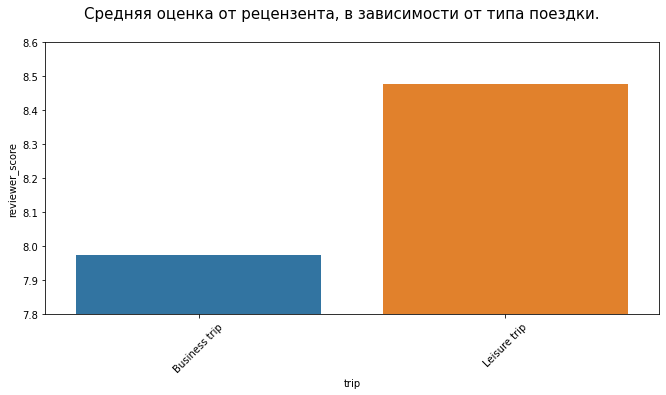

In [31]:
# Создадим таблицу с необходимыми данными для визуализации.
reviewer_score_trip = data[data['sample']==1].pivot_table(
    values='reviewer_score', 
    index='trip', 
    aggfunc='mean')

# Создаем столбчатую диаграмму.
plt.figure(figsize=(11, 5))
barplot_m = sns.barplot(
    data = reviewer_score_trip,
    x = reviewer_score_trip.index, 
    y = 'reviewer_score')

# Корректируем диаграмму для лучшей наглядности.
plt.suptitle('Средняя оценка от рецензента, в зависимости от типа поездки.',  
    fontsize=15)
plt.xticks(rotation= 45)
plt.ylim(7.8, 8.6);

##### Люди отправляющиеся на отдых в среднем ставят више оценки, чем те, кто едет в командировку.

#### Создадим признак поездка с животными.

In [32]:
# Создаем список.
pet_list = ['With a pet']

def pets(arg):
    """Функция нахождения тега поездки с животными. """
    for i in arg:
        if i in pet_list:
            return 1
    return 0

# Создаем признак поездки с животными.
data['with_pets'] = data['tags_new'].apply(pets)


def tags(arg):
    """Функция удаления использованих для анализа тегов."""
    for i in arg:
        if i in pet_list:
            arg.remove(i)
            return arg
    return arg

# Обновляем признак теги.
data['tags_new'] = data['tags_new'].apply(tags)

#### Создадим признак использования мобильного устройства.

In [33]:
# Создаем список.
other_list = ['Submitted from a mobile device']

def other(arg):
    """Функция нахождения тега использования мобильного устройства."""
    for i in arg:
        if i in other_list:
            return 1
    return 0

# Создаем признак.
data['Submitted from a mobile device'] = data['tags_new'].apply(other)


def tags(arg):
    """Функция удаления использованих для анализа тегов."""
    for i in arg:
        if i in other_list:
            arg.remove(i)
            return arg
    return arg

# Обновляем признак теги.
data['tags_new'] = data['tags_new'].apply(tags)

#### Создадим признак типа группы путешествующих.

In [34]:
# Создадим списки.
traveler_list_1 = ['Couple', 'Solo traveler']
traveler_list_2 = ['Group', 'Travelers with friends']
traveler_list_3 = ['Family with young children', 'Family with older children']

def traveler(arg):
    """Функция определения типа группы путешествующих."""
    for i in arg:
        if i in traveler_list_1:
            return i
        elif i in traveler_list_2:
            return 'Group'
        elif i in traveler_list_3:
            return 'Family'

# Создаем признак типа группы путешествующих.
data['traveler'] = data['tags_new'].apply(traveler)


traveler_list = traveler_list_1 + traveler_list_2 + traveler_list_3
def tags(arg):
    """Функция удаления использованих для анализа тегов."""
    for i in arg:
        if i in traveler_list:
            arg.remove(i)
            return arg
    return arg

# Обновляем признак теги.
data['tags_new'] = data['tags_new'].apply(tags)

#### Создадим признак количества проведенных ночей.

In [35]:
def night(arg):
    """Функция определения количества проведенных ночей"""
    if len(arg) != 0:
        arg = arg[-1]
        return arg
    
# Создаем признак.
data['night'] = data['tags_new'].apply(night)

# Обновляем признак теги.
data['tags_new'] = data['tags_new'].apply(lambda x: x[0] if len(x)!=0 else 0)

#### Создадим признаки о типе комнат.

##### Проведем некоторые преобразования над данными.

In [36]:
def rooms(arg):
    """Функция корректировки данных."""
    if arg == 0:
        return 0
    list_rooms = ['Classic', 'Basic']
    for i in list_rooms:
        if i in arg:
            arg = arg.replace(i, 'Standart')
            return arg
    return arg


def rooms2(arg):
    """Функция корректировки данных."""
    if arg == 0:
        return 0
    elif ' or ' in arg:
        arg = arg.replace(' or ', '/')
    elif 'Standart' in arg:
        arg = arg.replace('Standart', 'Standard')
    elif 'Economy' in arg:
        arg = arg.replace('Economy', 'Standard')
    elif '2' in arg:
        arg = arg.replace('2', 'Double')
    elif 'Queen' in arg:
        arg = arg.replace('Queen', 'Double')
    return arg


# Запускаем функции о преобразовании данных.
data['tags_new'] = data['tags_new'].apply(rooms)
data['tags_new'] = data['tags_new'].apply(rooms2)

#### Создадим признак типа комнаты в зависимости от вида кровати.

In [37]:
# Создаем список с видами кровати.
rooms_by_bed_list = ['Single', 'Triple', 'Double', 'Quadruple', 'King', 'Double/Twin', 'King/Twin']

def rooms_by_bed(arg):
    """Функция определения типа комнаты в зависимости от вида кровати."""
    if arg == 0:
        return None
    arg = arg.split()
    for i in rooms_by_bed_list:
        if i in arg:
            return i

# Создаем признак.
data['rooms_by_bed'] = data['tags_new'].apply(rooms_by_bed)

#### Создадим признак типа комнаты в зависимости от комфортности.

In [38]:
# Создаем список.
rooms_by_occupancy_list = ['Standard', 'Deluxe', 'Executive', 'Suite', 'Family', 'Superior', 'Cosy', 'Club', 'Comfort', 'Luxury']

def rooms_by_occupancy(arg):
    """Функция определения типа комнаты в зависимости от комфортности."""
    if arg == 0:
        return None
    arg = arg.split()
    for i in rooms_by_occupancy_list:
        if i in arg:
            return i
        
# Создаем признак.       
data['rooms_by_occupancy'] = data['tags_new'].apply(rooms_by_occupancy)

#### Создадим признак с дополнительными возможностяти.

In [39]:
# Создаем список.
privilege_list = ['View', 'Balcony', 'Terrace', 'Lounge', 'Spa']

def privilege(arg):
    """Функция определения дополнительных возможностей."""
    if arg == 0:
        return 0
    for i in privilege_list:
        if i in arg:
            return 1
    return 0

# Создаем признак.
data['privilege'] = data['tags_new'].apply(privilege)

### Произведем кодирование некоторых категориальных признаков.

#### Посмотрим информацию о нашем датасете.

In [40]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 515431 entries, 0 to 515430
Data columns (total 47 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515431 non-null  object 
 1   additional_number_of_scoring                515431 non-null  int64  
 2   review_date                                 515431 non-null  object 
 3   average_score                               515431 non-null  float64
 4   hotel_name                                  515431 non-null  object 
 5   reviewer_nationality                        515431 non-null  object 
 6   negative_review                             515431 non-null  object 
 7   review_total_negative_word_counts           515431 non-null  int64  
 8   total_number_of_reviews                     515431 non-null  int64  
 9   positive_review                             515431 non-null  object 
 

#### Произведем кодирование.

In [41]:
# Проведем OneHotEncoder для признака страна и город нахождения отеля.
encoder1 = ce.OneHotEncoder(cols=['country'])
country_bin = encoder1.fit_transform(data['country'])
data = pd.concat([data, country_bin], axis=1)

# Проведем OneHotEncoder для признака тональности негативного отзыва.
encoder1 = ce.OneHotEncoder(cols=['sentiment_type_neg'])
sentiment_type_neg_bin = encoder1.fit_transform(data['sentiment_type_neg'])
data = pd.concat([data, sentiment_type_neg_bin], axis=1)

# Проведем BinaryEncoder для признака наиболее часто встречающихся негативных отзывов.
bin_encoder = ce.BinaryEncoder(cols=['popular_negative_review'])
popular_negative_review_bin = bin_encoder.fit_transform(data['popular_negative_review'])
data = pd.concat([data, popular_negative_review_bin], axis=1)

# Проведем OneHotEncoder для признака тональности положительного отзыва.
encoder1 = ce.OneHotEncoder(cols=['sentiment_type_pos'])
sentiment_type_pos_bin = encoder1.fit_transform(data['sentiment_type_pos'])
data = pd.concat([data, sentiment_type_pos_bin], axis=1)

# Проведем BinaryEncoder для признака наиболее часто встречающихся положительных отзывов.
bin_encoder = ce.BinaryEncoder(cols=['popular_positive_review'])
popular_positive_review_bin = bin_encoder.fit_transform(data['popular_positive_review'])
data = pd.concat([data, popular_positive_review_bin], axis=1)

# Проведем OneHotEncoder для признака тип отдыха.
encoder1 = ce.OneHotEncoder(cols=['trip'])
trip_bin = encoder1.fit_transform(data['trip'])
data = pd.concat([data, trip_bin], axis=1)

# Проведем OneHotEncoder для признака тип группы путешествующих.
encoder1 = ce.OneHotEncoder(cols=['traveler'])
traveler_bin = encoder1.fit_transform(data['traveler'])
data = pd.concat([data, traveler_bin], axis=1)

# Проведем BinaryEncoder для признака количество проведенных ночей.
bin_encoder = ce.BinaryEncoder(cols=['night'])
night_bin = bin_encoder.fit_transform(data['night'])
data = pd.concat([data, night_bin], axis=1)

# Проведем OneHotEncoder для признака тип комнаты в зависимости от вида кровати.
encoder1 = ce.OneHotEncoder(cols=['rooms_by_bed'])
rooms_by_bed_bin = encoder1.fit_transform(data['rooms_by_bed'])
data = pd.concat([data, rooms_by_bed_bin], axis=1)

# Проведем OneHotEncoder для признака тип комнаты в зависимости от комфортности комнаты.
encoder1 = ce.OneHotEncoder(cols=['rooms_by_occupancy']) # указываем столбец для кодирования
rooms_by_occupancy_bin = encoder1.fit_transform(data['rooms_by_occupancy'])
data = pd.concat([data, rooms_by_occupancy_bin], axis=1)

### Отбор признаков.

In [42]:
# Скопируем основной датафрейм для дальнейших манипуляций по отбору признаков.
df = data.copy()

In [43]:
# Уберем из датафрейма все категориальные признаки.
object_columns = [s for s in df.columns if df[s].dtypes == 'object']
df.drop(object_columns, axis = 1, inplace=True)

In [44]:
# Выведем информацию по нашему датасету.
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 515431 entries, 0 to 515430
Data columns (total 77 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515431 non-null  int64  
 1   average_score                               515431 non-null  float64
 2   review_total_negative_word_counts           515431 non-null  int64  
 3   total_number_of_reviews                     515431 non-null  int64  
 4   review_total_positive_word_counts           515431 non-null  int64  
 5   total_number_of_reviews_reviewer_has_given  515431 non-null  int64  
 6   lat                                         515431 non-null  float64
 7   lng                                         515431 non-null  float64
 8   sample                                      515431 non-null  int64  
 9   reviewer_score                              515431 non-null  float64
 

### Мы получили 77 числовых признаков и без пропусков. 
#### Проведем корреляцию наших числовых признаков.

<AxesSubplot:>

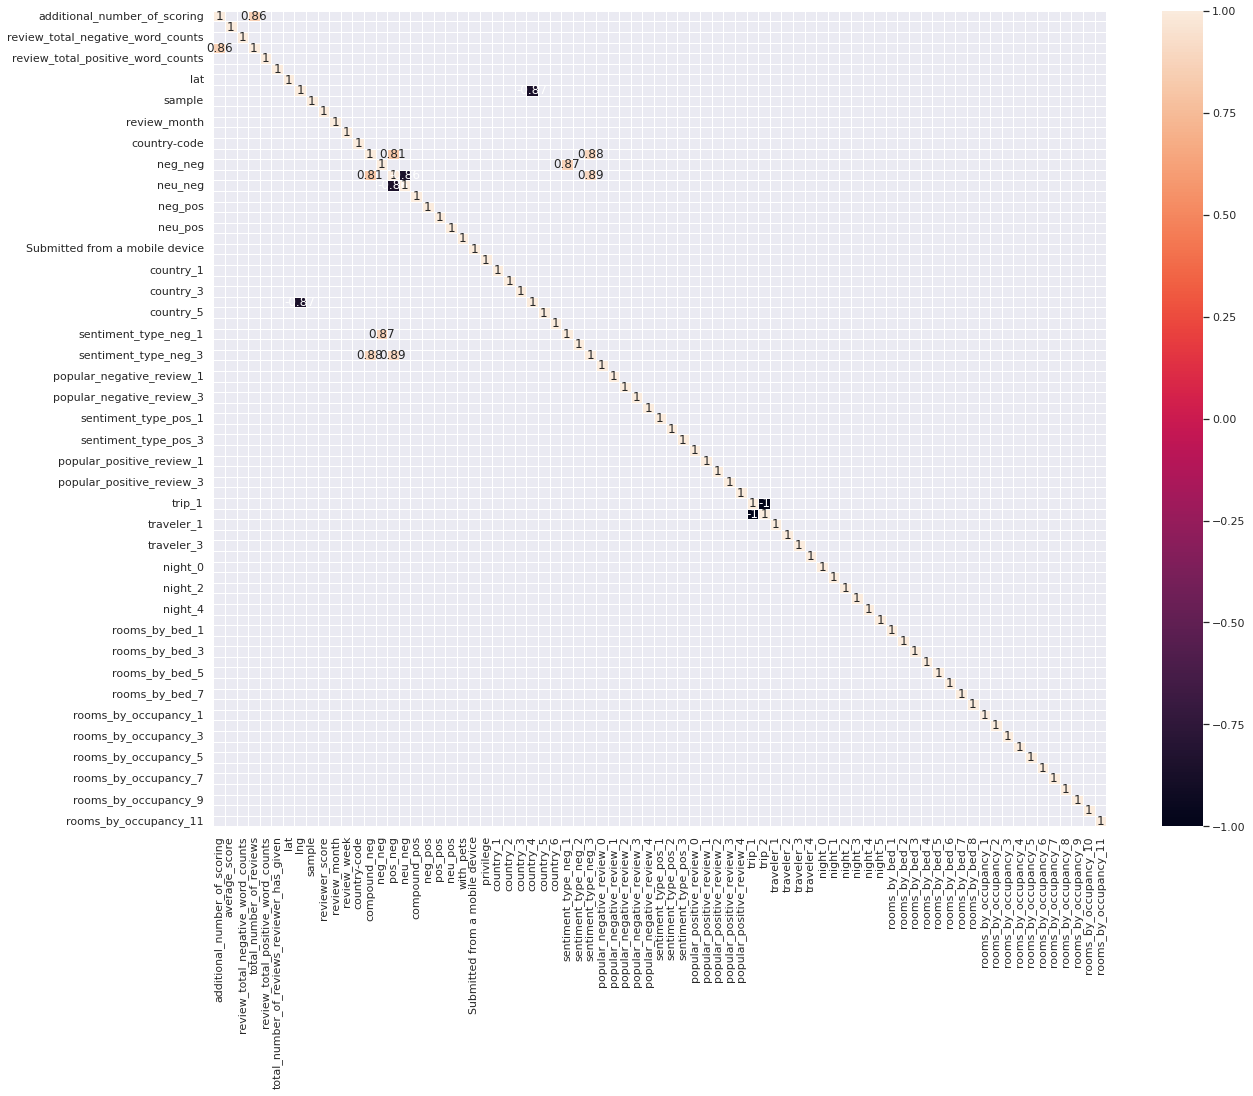

In [45]:
# Покажем корреляцию в виде тепловой карты.
sns.set()
fig, ax = plt.subplots(figsize=(20,15))
corr_df = df.corr(method='spearman')
# Отобразим корреляцию выше 80%.
sns.heatmap(corr_df[abs(corr_df) >= 0.8], annot=True, linewidths=.5, ax=ax)

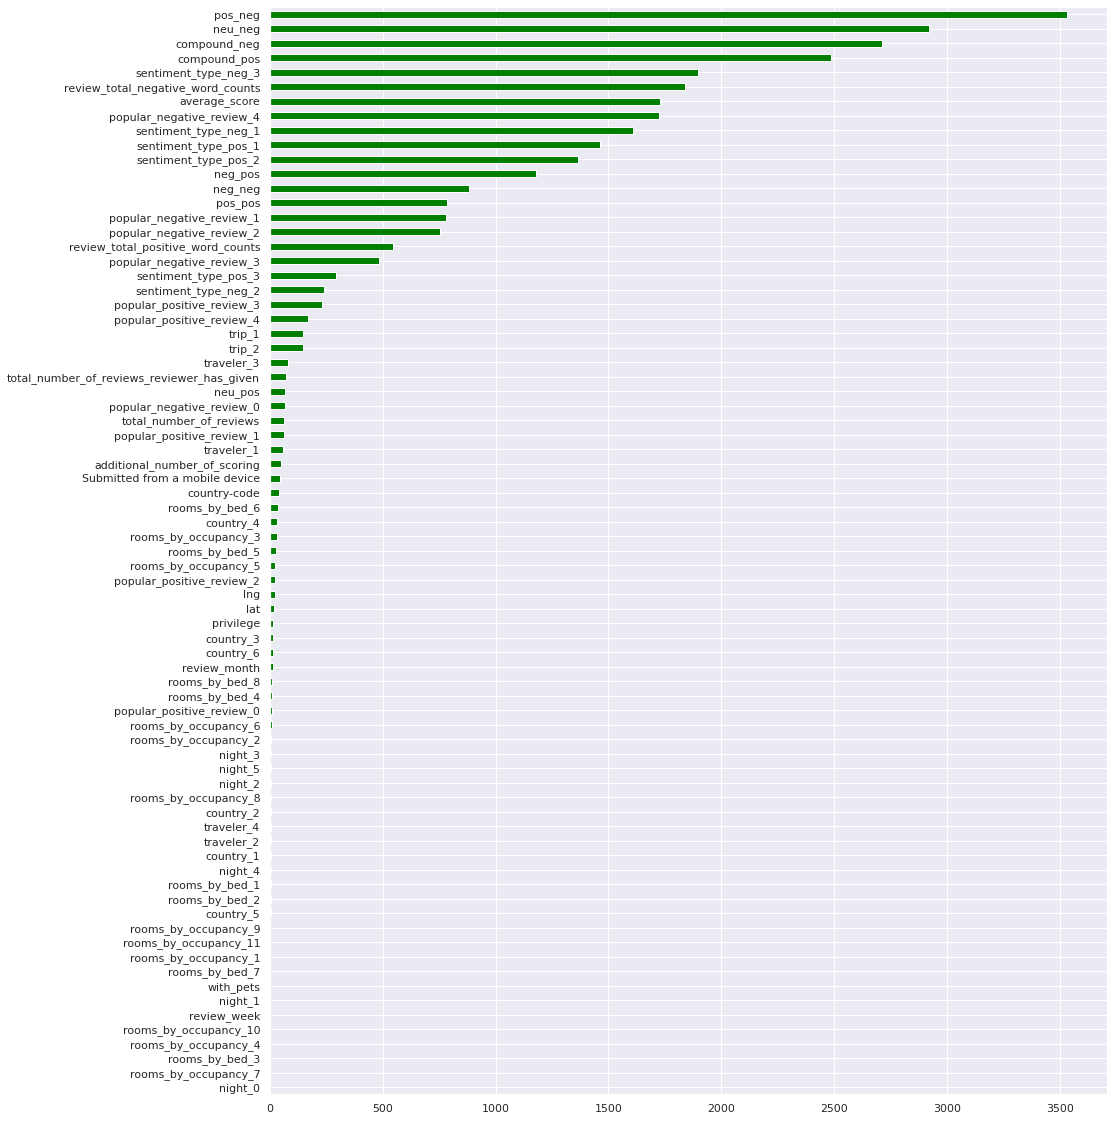

In [46]:
# Проведем оценку значимости признаков.
y = df.query('sample == 1').drop(['sample'], axis=1).reviewer_score.values
X = df.query('sample == 1').drop(['sample', 'reviewer_score'], axis=1)

# Визуализируем результат анализа значимости.
imp_num = pd.Series(f_classif(X[X.columns], y)[0], index = X.columns)
imp_num.sort_values(inplace = True)

fig5, ax5 = plt.subplots(figsize=(15, 20))
imp_num.plot(kind = 'barh', color='green');

In [47]:
# Удалим некоторые признаки с высокой корреляцией.
df.drop(['lat', 'lng', 'additional_number_of_scoring', 'trip_2', 'sentiment_type_neg_1', 'sentiment_type_pos_2'], axis = 1, inplace=True)

### Запускаем модель.

In [48]:
# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели.
train_data = df.query('sample == 1').drop(['sample'], axis=1)
test_data = df.query('sample == 0').drop(['sample'], axis=1)

# Х - данные с информацией об отелях, у - целевая переменная (рейтинги отелей).
y = train_data.reviewer_score.values 
X = train_data.drop(['reviewer_score'], axis=1)

# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Создаём модель.  
regr = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=42)
      
# Обучаем модель на тестовом наборе данных.
regr.fit(X_train, y_train)  
      
# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.  
# Предсказанные значения записываем в переменную y_pred.
y_pred = regr.predict(X_test)  

# Сравниваем предсказанные значения (y_pred) с реальными (y_test).
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.9min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s


MAPE: 0.12274025236842499


[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.6s finished


#### Значение МАРЕ получилось 0.12274

In [49]:
# Выполняем предсказание на тестовых данных.
test_data = test_data.drop(['reviewer_score'], axis=1)
predict_submission = regr.predict(test_data)
submission['reviewer_score'] = predict_submission

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    4.0s finished


In [50]:
# Сохраним полученные данные и сделаем сабмит.
submission.to_csv('submission.csv', index=False)